In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 

Image.MAX_IMAGE_PIXELS = None

In [8]:
%matplotlib inline

# Visulisation Image

In [9]:
village_img = Image.open('village_image.tif')

KeyboardInterrupt: 

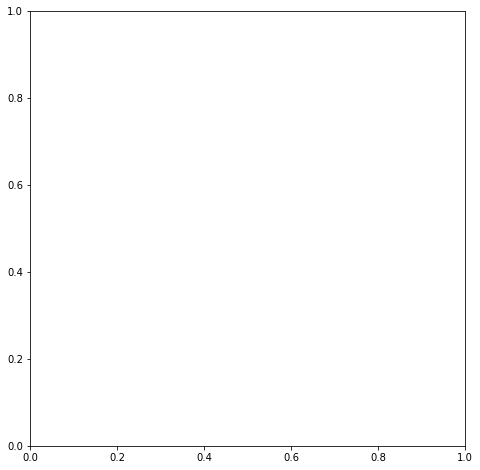

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(village_img)
plt.show()

## Cropped Image

In [10]:
area = (11000,7500,15000,11500)
small_village_img = village_img.crop(area)
small_village_img = small_village_img.resize((1000,1000), Image.ANTIALIAS)


In [11]:
small_village_img = Image.open('small_village.jpg')

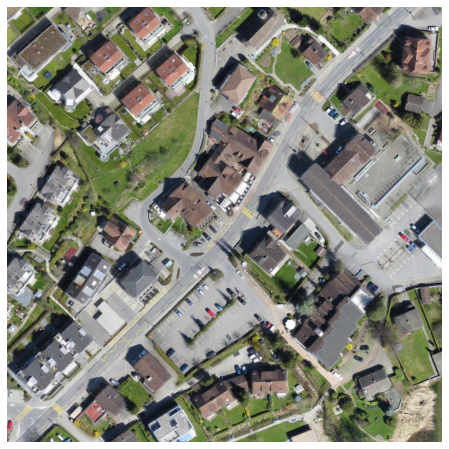

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(small_village_img)
plt.axis('off')
plt.show()

### Creation of the patchs

In [13]:
colors = ['b','g','r','c','m','y','k','w']

def patchs(img,n_patchs=2,size_patch=200):
    n,p = img.size
    area_patch = []
    shared_pos = {}
    for k in range(n_patchs):
        shared_pos[k] =[]

    #Initialization 1st image
    x_init,y_init = np.random.randint(n-2*size_patch)+size_patch, np.random.randint(p-2*size_patch)+size_patch
    area_patch.append((x_init,y_init,x_init+size_patch,y_init+size_patch))

    for t in range(n_patchs-1):
        choose_patch = np.random.randint(t+1)
        area_shared = area_patch[choose_patch]

        x_shared = np.random.randint(max(size_patch,area_shared[0]),min(n-size_patch,area_shared[2])) 
        y_shared = np.random.randint(max(size_patch,area_shared[1]),min(p-size_patch,area_shared[3]))

        pos_x_shared = np.random.randint(size_patch)
        pos_y_shared = np.random.randint(size_patch)
        area = (x_shared -pos_x_shared,y_shared - pos_y_shared, x_shared -pos_x_shared + size_patch, y_shared - pos_y_shared+size_patch)

        shared_pos[choose_patch].append((x_shared - area_shared[0],y_shared - area_shared[1], colors[t], t+1))  
        shared_pos[t+1].append((pos_x_shared,pos_y_shared, colors[t],  choose_patch))
        area_patch.append(area)
    return area_patch, shared_pos



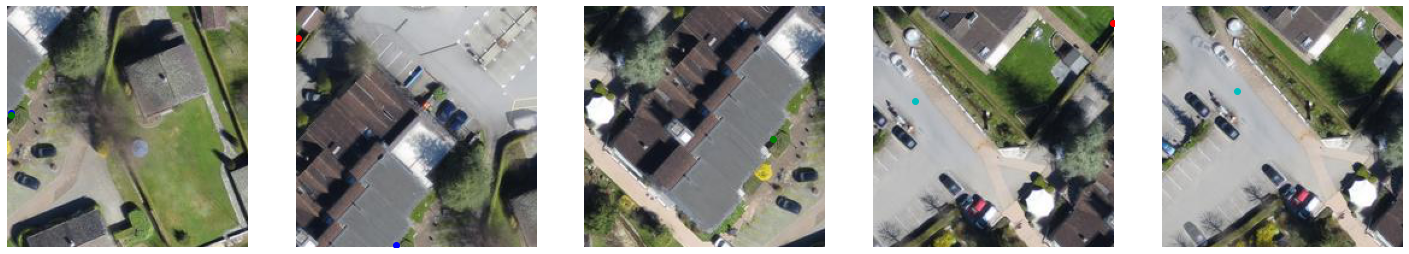

In [14]:
n_patchs = 5

list_patch, list_pos = patchs(small_village_img,n_patchs=n_patchs,size_patch=200)


fig, axs = plt.subplots(1,n_patchs,figsize=(25,5))
for k in range(len(list_patch)):
    patch = small_village_img.crop(list_patch[k])
    axs[k].imshow(patch)
    axs[k].set_axis_off()
    for pos in list_pos[k]:
        axs[k].scatter(pos[0],pos[1],c=pos[2])

plt.show()


#### Stitching images

In [33]:
def stitch(list_img, shared_pos):

    stitched_img = list_img[0]
    n = len(list_img)
    size_patch, _, _ = stitched_img.shape

    X_pos = np.zeros((n,n))
    Y_pos = np.zeros((n,n))

    #POsition of the shared point in the different images
    for k in range(n):
        for pos in shared_pos[k]:
            X_pos[k,pos[3]] = pos[1]
            Y_pos[k,pos[3]] = pos[0]

    for k in range(1,n):
        new_img = list_img[k]
        pos = shared_pos[k][0]
        img_idx = pos[3]


        translation = int(X_pos[img_idx,k] - pos[1]), int(Y_pos[img_idx,k] - pos[0])

        X_pos[k] += max(0,translation[0])
        Y_pos[k] += max(0,translation[1])

        X_pos[:k,:] += max(0, -translation[0])
        Y_pos[:k,:] += max(0, -translation[1])


        n_stitch,p_stitch,_ = stitched_img.shape
        n_new,p_new,_ = new_img.shape

        stiched_image_shape = (n_stitch+ abs(translation[0])), (p_stitch+abs(translation[1])), 3 

        #print('Image {}: stitch image size = {} and translation = {}'.format(k,stitched_img.shape,translation))

        new_stitched_img = np.zeros(stiched_image_shape)
        previous_image_stitched =  np.zeros(stiched_image_shape)
        new_image_stitched =  np.zeros(stiched_image_shape)

        new_image_stitched[max(0,translation[0]):n_new+max(0,translation[0]),
                              max(0,translation[1]):p_new+max(0,translation[1])] = new_img

        previous_image_stitched[-min(0,translation[0]):n_stitch-min(0,translation[0]),
                            -min(0,translation[1]):p_stitch-min(0,translation[1])] = stitched_img

        for i in range(stiched_image_shape[0]):
            for j in range(stiched_image_shape[1]):
                if (previous_image_stitched[i,j] == np.zeros(3)).all():
                    new_stitched_img[i,j] = new_image_stitched[i,j]
                else:
                    new_stitched_img[i,j] = previous_image_stitched[i,j]

        stitched_img = np.copy(new_stitched_img)
        

    line = np.sum(stitched_img,axis=1)
    column = np.sum(stitched_img,axis=0)
    
    end_line = np.where(line == 0)[0][0]
    end_column = np.where(column ==0)[0][0]

    return stitched_img[:end_line,:end_column]


In [34]:
list_img = []

imgs = []

for k in range(len(list_patch)):
    patch = small_village_img.crop(list_patch[k])
    img = np.asarray(patch, dtype="int32")/255
    list_img.append(img)
    imgs.append(np.array(patch,dtype=np.uint8))

In [35]:
cropped_img = stitch(list_img,list_pos)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(cropped_img)
plt.axis('off')
plt.show()


NameError: name 'cropped_img' is not defined

<Figure size 576x576 with 0 Axes>

# Creation of the features

In [18]:
def kp_list_2_opencv_kp_list(kp_list,window_size):

    opencv_kp_list = []
    for kp in kp_list:
        opencv_kp = cv2.KeyPoint(x=kp[0],
                                 y=kp[1],
                                 _size=window_size * 2.0,
                                 )
        opencv_kp_list += [opencv_kp]

    return opencv_kp_list

In [19]:
def descriptors_features(img,ksize=2,k=0.04, threshold = 0.1,window_size = 3):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    n,p,_ = img.shape

    dst = cv2.cornerHarris(gray,ksize,5,k)
    
    kp = np.where(dst>threshold*dst.max())
    
    keypoints = []
    descriptors = []
    for point in range(kp[0].shape[0]):
        if (kp[0][point] > window_size and kp[0][point] < n - window_size - 1) and (kp[1][point] > window_size and kp[1][point] < p - window_size - 1):
            #keypoints.append([kp[0][point], kp[1][point]])
            
            opencv_kp = cv2.KeyPoint(x=float(kp[1][point]),
                                 y=float(kp[0][point]),
                                 _size=window_size * 2.0
                                 )
            
            keypoints.append(opencv_kp)
            patch = gray[kp[0][point] - window_size: kp[0][point] + window_size+1,
                        kp[1][point] - window_size: kp[1][point] + window_size+1].flatten()
            
            descriptors.append(patch)
            

    
    return keypoints, np.array(descriptors)

In [20]:
img_test = np.copy(imgs[0])
kp, desc = descriptors_features(img_test, ksize = 4, k = 0.04, threshold = 0.05)

points = cv2.KeyPoint_convert(kp)

for point in points:
    img_test[int(point[1]),int(point[0])] = [255,0,0]

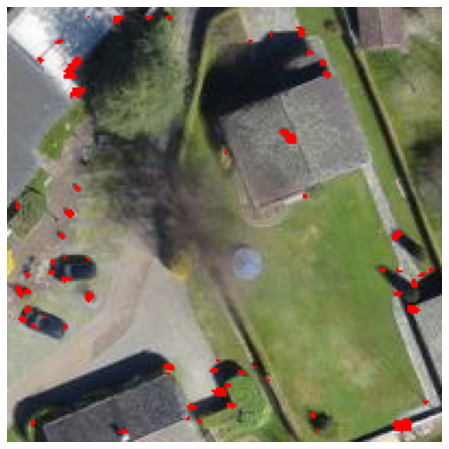

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(img_test)
plt.axis('off')
plt.show()

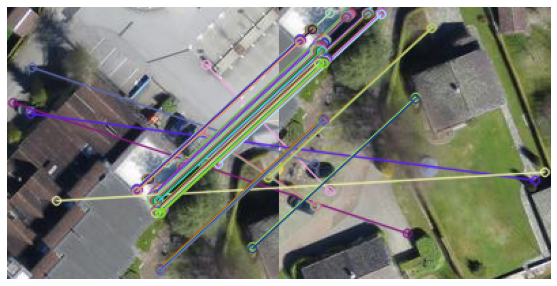

In [22]:
def match_descriptors(descriptors1, descriptors2):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1,descriptors2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance: #lowe ratio
            good.append([m])
            
    return good


img1 = np.copy(imgs[1])
kp1, desc1 = descriptors_features(img1, ksize = 4, k = 0.04, threshold = 0.05)

img2 = np.copy(imgs[0])
kp2, desc2 = descriptors_features(img2, ksize = 4, k = 0.04, threshold = 0.05)

good = match_descriptors(desc1, desc2)
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.figure(figsize=(10,5))
plt.imshow(img3)
plt.axis('off')
plt.show()

**Info DMatch** : https://stackoverflow.com/questions/16996800/what-does-the-distance-attribute-in-dmatches-mean

DMatch.distance - Distance between descriptors. The lower, the better it is.

DMatch.trainIdx - Index of the descriptor in train descriptors(1st image)

DMatch.queryIdx - Index of the descriptor in query descriptors(2nd image)

DMatch.imgIdx - Index of the train image.

In [23]:
N = len(good)

n = np.random.randint(N)

idx1 , idx2 = good[n][0].trainIdx, good[n][0].queryIdx
print(idx1)
print(idx2)
shared_pos = [kp1[idx1].pt, kp2[idx2].pt]

for k in range(len(shared_pos)):
    shared_pos[k] = (int(shared_pos[k][0]),int(shared_pos[k][1]),'r')


new_img = [img1,img2]
    
fig, axs = plt.subplots(1,2,figsize=(10,5))
for k in range(len(new_img)):
    axs[k].imshow(new_img[k])
    axs[k].set_axis_off()
    axs[k].scatter(shared_pos[k][1],shared_pos[k][0],c=shared_pos[k][2])

plt.show()

120
668


IndexError: list index out of range

In [24]:
good[0][0]

<DMatch 0x7fa8401345f0>

In [25]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
val = img1.shape[1] + img2.shape[1]
result_image = cv2.warpPerspective(img1, M, (val , img1.shape[0]))
result_image[0:img2.shape[0], 0:img2.shape[1]] = img2


In [26]:
M

array([[ 9.99886801e-01, -4.39061179e-04, -7.99480200e+01],
       [ 5.64499834e-04,  9.98336620e-01, -1.09851543e+02],
       [ 6.94618611e-06, -1.07738930e-05,  1.00000000e+00]])

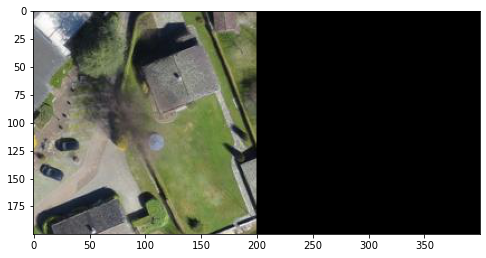

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(result_image)
plt.show()

In [28]:
def panorama_auto_stitch(list_imgs, m = 2):
    n = len(list_imgs)
    adj_matrix = np.zeros((n,n))
    
    for i in range(n-1):
        for j in range(i+1,n): 
            kp1, desc1 = descriptors_features(list_imgs[i], ksize = 4, k = 0.04, threshold = 0.05)
            kp2, desc2 = descriptors_features(list_imgs[j], ksize = 4, k = 0.04, threshold = 0.05)

            good = match_descriptors(desc1, desc2)
            
            adj_matrix[i,j] = len(good)
            
    
    inliners = np.zeros((n,n))
    
    for i in range(n):
        best_match = sorted(range(n),key= lambda k: adj_matrix[i,k],reverse=True)
        for best_idx in best_match[:m]:
            
            kp1, desc1 = descriptors_features(list_imgs[i], ksize = 4, k = 0.04, threshold = 0.05)
            kp2, desc2 = descriptors_features(list_imgs[best_idx], ksize = 4, k = 0.04, threshold = 0.05)

            good = match_descriptors(desc1, desc2)
            
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            
            inliners[i,best_idx] = matchesMask.count(1)
            
    
            
            
    
            
            
            

            

In [29]:
s = [2, 3, 1, 4, 5, 3]
sorted(range(len(s)), key=lambda k: s[k],reverse=True)
[2, 0, 1, 5, 3, 4]

[2, 0, 1, 5, 3, 4]

### SIFT

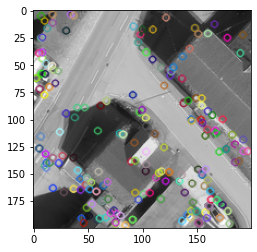

In [30]:
img = cv2.imread('img_test.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp,img)
#cv.imwrite('sift_keypoints.jpg',img)

plt.figure()
plt.imshow(img)
plt.show()

In [31]:
img = cv2.imread('img_test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# detect and extract features from the image
descriptors = cv2.xfeatures2d.SIFT_create()
(Keypoints, features) = descriptors.detectAndCompute(img, None)

Keypoints = np.float32([i.pt for i in Keypoints])

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [32]:
features[0]

NameError: name 'features' is not defined

# References

Github: https://github.com/aartighatkesar/Image-Mosaicing

Image stitching library: https://www.pyimagesearch.com/2018/12/17/image-stitching-with-opencv-and-python/

https://mono.software/2018/03/14/Image-stitching/

https://github.com/alexhagiopol/orthomosaic

https://github.com/luna983/stitch-aerial-photos

 Automatic Panoramic Image Stitching using Invariant Features. : https://hypjudy.github.io/2017/05/10/panorama-image-stitching/

Implemention of Matthew paper: https://github.com/avinashk442/Panoramic-Image-Stitching-using-invariant-features/blob/master/panorama.py

https://github.com/sheoranhimansh/AutoPanorama